Exam SDS – Jonathan Sauer – Matrikelnummer 2268619 – 11.12.2025 

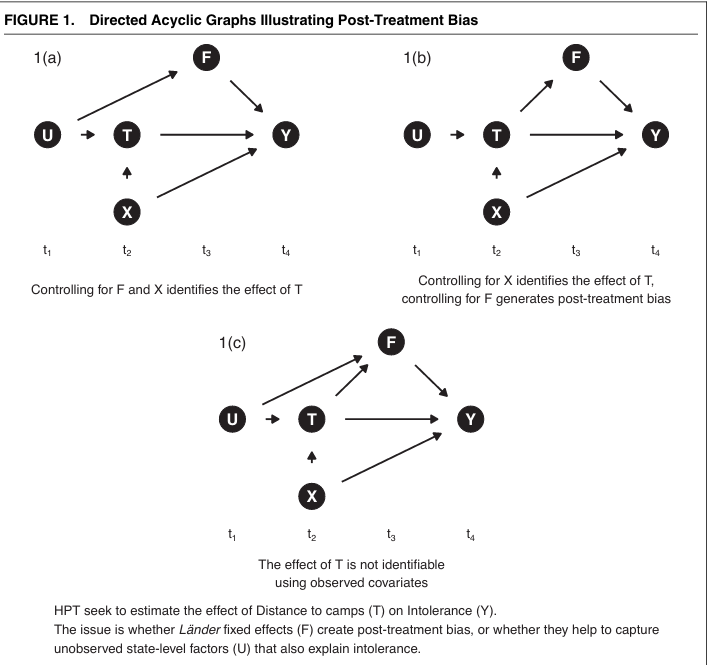
# Q1 DAG
The authors argue that Länder (F) are not posttreatment variables because they are not causally downstream from distance to concentration camps (T). This means that the distance to camps did not determine or affect state boundaries. Therefore, controlling for Länder as fixed effects appropriately controls for bias introduced by regional heterogeneity rather than creating posttreatment bias.
The authors provide compelling evidence that most contemporary Länder boundaries existed before the Nazi era. As shown in Figure 3 of their paper, many current state boundaries correspond to Weimar-era states or even earlier political units (e.g., Bavaria, Saxony, Hesse). Other boundaries were determined by postwar Allied occupation zones, not by camp locations. This historical evidence demonstrates that F is not a consequence of T.
In our analytical setup, only Figure 1a is the correct DAG because:

Assumption 1 holds (No effect of treatment on confounder): In Figure 1a, F is not a descendant of T. Since camp proximity did not cause or determine Länder boundaries, controlling for F does not create posttreatment bias. The temporal sequence (F measured after T) is irrelevant - what matters is the causal structure, not the timing of measurement.
Assumption 2 holds (No M-bias): Figure 1a shows that F is not a collider created by unobserved variables that also cause T or Y. Instead, F captures unobserved regional characteristics (U) that confound the relationship between Distance and Intolerance.
Backdoor path requires adjustment: There exists a backdoor path T ← U → F → Y that must be blocked to identify the causal effect. Regional factors (U) such as historical political culture, religious composition, and economic characteristics influence both where camps were located and contemporary state-level policies that affect intolerance. By controlling for F through fixed effects, we block this confounding path.

In contrast, Figure 1b incorrectly assumes camp proximity caused state boundaries (violating historical evidence), and Figure 1c represents an unidentifiable scenario where F is both a confounder and a posttreatment variable. Neither alternative matches the historical and theoretical reality described by Pepinsky et al.



# Q 1b
## Scenario 1: Figure 1a (Control for F)

Concrete Example:
Let F represent state-level education policy regarding Holocaust education. Suppose certain Länder (e.g., Bavaria) have historically had less comprehensive civic education about the Holocaust compared to others (e.g., Berlin), due to regional political culture that pre-dates the camps.
Causal Mechanism:

Regional political culture (U) influences both where camps were located (Distance) and contemporary education policy (F)
For example, more conservative regions might have had more camps built near them AND independently developed less progressive educational curricula
Education policy (F) directly affects Intolerance - better Holocaust education reduces intolerance
The relationship between Distance and Intolerance is confounded by these state-level differences in education

Fixed Effects Implication:
We MUST control for F (state fixed effects). Without controlling for state differences in education policy, we would incorrectly attribute the effect of poor education to camp proximity. The fixed effects isolate the within-state variation in distance, removing the confounding influence of state-level educational approaches.

## Scenario 2: Figure 1b (Do NOT control for F)
Concrete Example:
Suppose F represents the intensity of current state-sponsored memorial activities. Imagine that states with closer proximity to camps (smaller Distance) responded by creating more active memorial programs and museum funding.
Causal Mechanism:

Camp proximity (Distance) directly causes states to invest differently in memorial infrastructure (F)
States with nearby camps feel greater responsibility to preserve history and educate citizens
These memorial activities (F) then affect Intolerance by increasing awareness and reducing prejudice
Here, F is a mediator - it lies on the causal path from Distance → F → Intolerance

Fixed Effects Implication:
We should NOT control for F. Controlling for memorial activities would block the causal pathway through which camp proximity affects intolerance. This would induce posttreatment bias by removing the very mechanism we're trying to measure. We would underestimate (or completely eliminate) the true effect of proximity.

## Scenario 3: Figure 1c (Unidentifiable)
Concrete Example:
Let F represent contemporary state-level refugee settlement policies. Suppose both camp proximity AND refugee policy are influenced by deeper historical factors (U) - for instance, historical patterns of ethnic diversity and openness that pre-date both the camps and modern policy.
Causal Mechanism:

Unobserved historical ethnic composition (U) affects where camps were built (Distance)
The same historical factor (U) creates a backdoor path to current state refugee policy (F)
However, camp proximity ALSO causes changes in state refugee policy (Distance → F) - states with nearby camps might adopt either more welcoming OR more restrictive policies as a response
Refugee policy (F) directly affects Intolerance independent of camps

Fixed Effects Implication:
The causal effect is UNIDENTIFIABLE with observed data alone. We face a dilemma: not controlling for F leaves the backdoor path U → F → Y open, but controlling for F creates posttreatment bias because F is also caused by Distance. Without directly measuring U (the unobserved historical ethnic composition), we cannot separate the effect of proximity from these confounding factors. This represents a fundamental identification problem.

In [137]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white
from statsmodels.regression.linear_model import OLS
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(12435)


In [138]:
# Load datasets
evs = pd.read_csv('data/replication_archive/tables/EVS_main.csv')
evs_weimar = pd.read_csv('data/replication_archive/tables/evs_weimar.csv')
elections = pd.read_csv('data/replication_archive/tables/elections_2017.csv')

print(f"EVS Main Dataset: {evs.shape[0]} observations, {evs.shape[1]} variables")
print(f"EVS Weimar Dataset: {evs_weimar.shape[0]} observations, {evs_weimar.shape[1]} variables")
print(f"2017 Elections Dataset: {elections.shape[0]} observations, {elections.shape[1]} variables")
print("\nEVS Main - First few rows:")

# Recode state names for better display
state_names = {
    'DE1': 'WEST:\nBaden-Wurttemberg',
    'DE2': 'WEST:\nBavaria',
    'DE3': 'EAST:\nBerlin',
    'DE4': 'EAST:\nBrandenburg',
    'DE5': 'WEST:\nBremen',
    'DE6': 'WEST:\nHamburg',
    'DE7': 'WEST:\nHessen',
    'DE8': 'EAST:\nMecklenburg-Vorpommern',
    'DE9': 'WEST:\nLower Saxony',
    'DEA': 'WEST:\nNorth Rhine-Westphalia',
    'DEB': 'WEST:\nRhineland Palatinate',
    'DEC': 'WEST:\nSaarland',
    'DED': 'EAST:\nSaxony',
    'DEE': 'EAST:\nSaxony-Anhalt',
    'DEF': 'WEST:\nSchleswig-Holstein',
    'DEG': 'EAST:\nThuringia'
}

evs['state_name'] = evs['state'].map(state_names)
evs['f_state'] = evs['state'].astype('category')

# Summary statistics by state
print("Mean Intolerance by State:")
state_summary = evs.groupby('state_name')['intolerance'].agg(['mean', 'count'])
state_summary.sort_values('mean', ascending=False)
evs.head()

EVS Main Dataset: 2075 observations, 20 variables
EVS Weimar Dataset: 2052 observations, 77 variables
2017 Elections Dataset: 11302 observations, 37 variables

EVS Main - First few rows:
Mean Intolerance by State:


,kreise,Distance,closest_camp,unemp,educ,west,female,age,urban_scale,lr,...,prop_jewish25,unemployment33,population25,nazishare33,intolerance,resentment,far_right,state,state_name,f_state
0,-,15.969231,Neuengamme,0.0,5.0,1,0,63.0,6,5.0,...,0.000966,0.129652,0.596945,0.485495,-0.378253,5.883597,0,DEF,WEST:\nSchleswig-Holstein,DEF
1,-,15.969231,Neuengamme,0.0,5.0,1,0,49.0,6,NaN,...,0.000966,0.129652,0.596945,0.485495,0.898075,-2.047545,0,DEF,WEST:\nSchleswig-Holstein,DEF
2,-,15.969231,Neuengamme,1.0,8.0,1,1,28.0,6,NaN,...,0.000966,0.129652,0.596945,0.485495,-0.378253,-5.604500,0,DEF,WEST:\nSchleswig-Holstein,DEF
3,-,15.969231,Neuengamme,1.0,5.0,1,1,53.0,6,5.0,...,0.000966,0.129652,0.596945,0.485495,0.348260,5.711561,0,DEF,WEST:\nSchleswig-Holstein,DEF
4,-,15.969231,Neuengamme,0.0,5.0,1,0,72.0,6,7.0,...,0.000966,0.129652,0.596945,0.485495,0.396214,3.275474,0,DEF,WEST:\nSchleswig-Holstein,DEF


In [139]:
# basic linear regression with statmodels
model = smf.ols('intolerance ~ age + female', data=evs).fit()
print("\nOLS Regression Results:")
print(model.summary())


OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:            intolerance   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.637
Date:                 Do, 11 Dez 2025   Prob (F-statistic):            0.00979
Time:                        10:30:49   Log-Likelihood:                -2159.8
No. Observations:                2075   AIC:                             4326.
Df Residuals:                    2072   BIC:                             4343.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0971      

In [140]:
# missing value stats
missing_stats = evs.isnull().mean() * 100
print("\nMissing Value Statistics (%):")
print(missing_stats[missing_stats > 0])


Missing Value Statistics (%):
unemp            0.192771
educ             0.240964
lr              33.253012
immigrants07     0.819277
dtype: float64


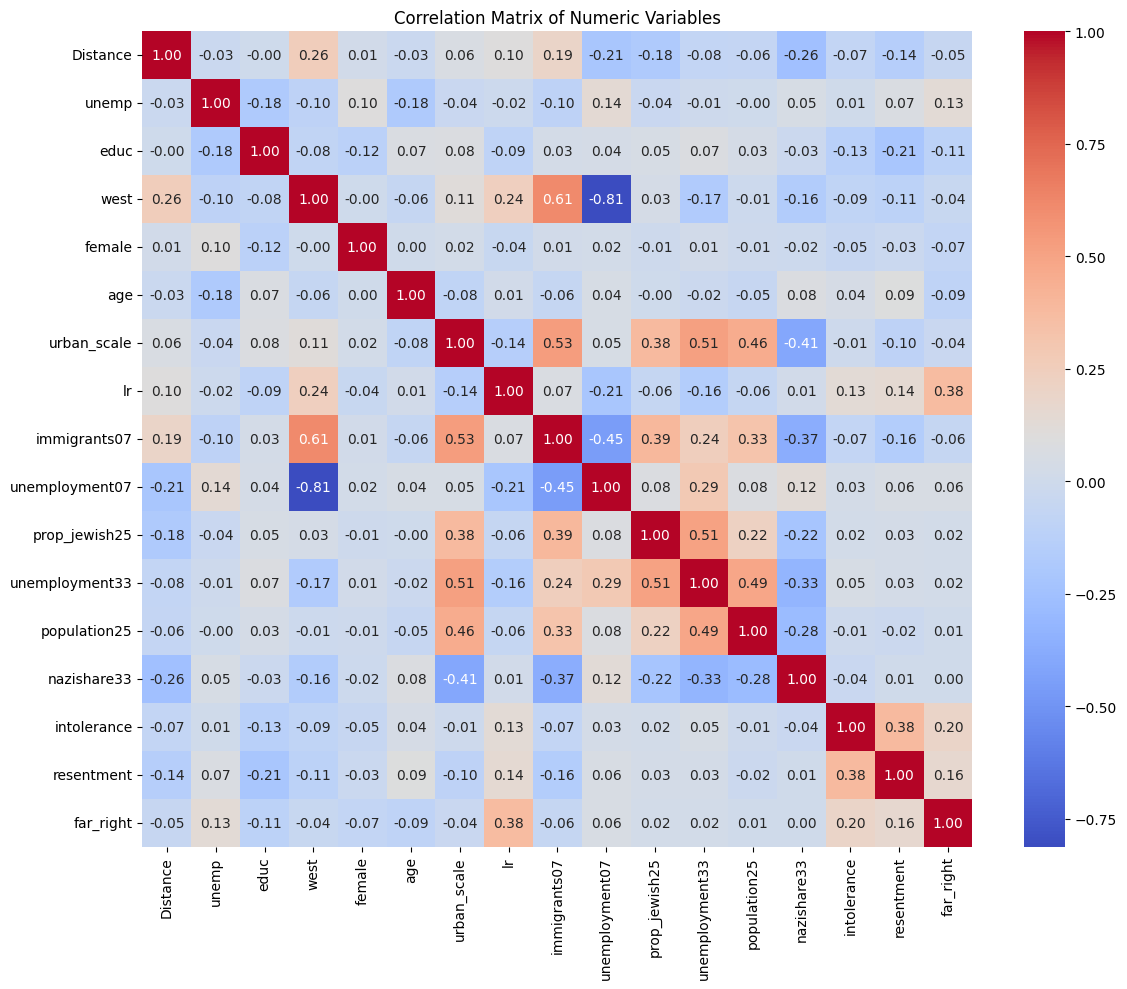

In [141]:
# corrplot from numeric values
numeric_cols = evs.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

In [142]:
# generate dicts for y and X variables and controls
y = {
    'intolerance': 'Intolerance Score'
}
X = {
    'urban_scale': 'Distance to Nearest Border (km)',
    'age': 'Age',
    'female': 'Female (1=Yes)',
    'educ': 'Education',
    'unemp': 'Unemployed (1=Yes)',
    'Distance': 'Distance to concentration camp (km)',
    'lr': 'Left-Right Self-Placement',
    'west': 'West Germany (1=Yes)',
    'immigrants07': 'Immigrants in 2007 (%)',
    'prop_jewish25': 'Proportion Jewish Population 1925 (%)',
    'unemployment33': 'Unemployment Rate 1933 (%)',
    'population25': 'Population Density 1925',
    'nazishare33': 'Nazi Vote Share 1933 (%)',
}
controls = {
 #  'state': 'State fixed effects (one-hot)',
}

# helper to build design matrix with fixed effects
def build_design_matrix(df, base_features, control_cats):
    X_base = df[base_features].copy()
    if control_cats:
        dummies = []
        for col in control_cats:
            dummy = pd.get_dummies(df[col], prefix=col, drop_first=True)
            dummies.append(dummy)
        if dummies:
            X_base = pd.concat([X_base] + dummies, axis=1)
    return X_base

# select feature/target columns up front and add controls
feature_cols = list(X.keys())
target_cols = list(y.keys())
control_cols = list(controls.keys())
design_matrix = build_design_matrix(evs, feature_cols, control_cols)

# do train test split
X_train_df, X_test_df, y_train, y_test = train_test_split(design_matrix, evs[target_cols], test_size=0.2, random_state=42)

# scale features and keep column names
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train_df),
    columns=X_train_df.columns,
    index=X_train_df.index,
)
X_test = pd.DataFrame(
    scaler.transform(X_test_df),
    columns=X_test_df.columns,
    index=X_test_df.index,
)


# define dict for sklearn models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
models = {
    'OLS': LinearRegression(),
    'RF-Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
  #  'Logistic Regression': LogisticRegression(max_iter=1000),
    'Simple desicion tree': DecisionTreeRegressor(random_state=42),
    'SVM': SVR(kernel='linear'),
}
# imputing missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index,
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index,
)

# fit models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MSE: {mse:.3f}, R²: {r2:.3f}")

OLS - MSE: 0.529, R²: 0.043
RF-Regressor - MSE: 0.350, R²: 0.366
Gradient boosting - MSE: 0.394, R²: 0.287
Ridge Regression - MSE: 0.529, R²: 0.043
Lasso Regression - MSE: 0.557, R²: -0.007
Simple desicion tree - MSE: 0.511, R²: 0.076
SVM - MSE: 0.708, R²: -0.281


In [143]:
def regression_evaluation(
    models: ModelInput,
    X_test,
    y_test,
    *,
    title: str | None = None,
    control_prefixes: Sequence[str] | None = None,
) -> Dict[str, Dict[str, float]]:
    """Evaluate fitted regressors, plot diagnostics, and summarize metrics."""
    if hasattr(X_test, "columns"):
        feature_names = list(X_test.columns)
        X = np.asarray(X_test.to_numpy())
    else:
        X = np.asarray(X_test)
        feature_names = []
    y = np.asarray(y_test).ravel()
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if y.ndim != 1:
        y = y.ravel()
    if X.shape[0] != y.shape[0]:
        raise ValueError(f'X rows ({X.shape[0]}) and y length ({y.shape[0]}) differ. Ensure matching train/test splits and no NaNs are dropped differently.')
    if not feature_names:
        feature_names = [f"feature_{i}" for i in range(X.shape[1])]

    if isinstance(models, Sequence) and not isinstance(models, RegressorMixin):
        named_models = list(models)
    else:
        named_models = [("model", models)]

    results: Dict[str, Dict[str, float]] = {}
    scalar_metrics: Dict[str, Dict[str, float]] = {}
    feature_importances: Dict[str, np.ndarray | None] = {}
    coef_models: Dict[str, np.ndarray] = {}
    colors = sns.color_palette("tab10", len(named_models))
    color_map: Dict[str, Tuple[float, float, float]] = {}

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    if title:
        fig.suptitle(title)

    cooks_fig, cooks_ax = plt.subplots(figsize=(9, 4))
    qq_quantiles = stats.norm.ppf((np.arange(1, X.shape[0] + 1) - 0.5) / X.shape[0])
    diag_min = y.min()
    diag_max = y.max()

    for idx, (name, model) in enumerate(named_models):
        y_pred = np.asarray(model.predict(X)).ravel()
        residuals = y - y_pred
        n, p = X.shape

        diag_min = min(diag_min, y_pred.min())
        diag_max = max(diag_max, y_pred.max())

        adj_r2 = 1 - (1 - r2_score(y, y_pred)) * (n - 1) / max(n - p - 1, 1)
        X_design = np.c_[np.ones(n), X]
        lm_stat, lm_pvalue, _, _ = het_breuschpagan(residuals, X_design)
        dw = durbin_watson(residuals)
        jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
        vif = [variance_inflation_factor(X, j) for j in range(p)]

        metrics = {
            "r2": r2_score(y, y_pred),
            "adj_r2": adj_r2,
            "explained_variance": explained_variance_score(y, y_pred),
            "rmse": root_mean_squared_error(y, y_pred),
            "mse": mean_squared_error(y, y_pred),
            "mae": mean_absolute_error(y, y_pred),
            "medae": median_absolute_error(y, y_pred),
            "mape": mean_absolute_percentage_error(y, y_pred),
            "breusch_pagan_stat": lm_stat,
            "breusch_pagan_p": lm_pvalue,
            "durbin_watson": dw,
            "jarque_bera_stat": jb_stat,
            "jarque_bera_p": jb_pvalue,
            "vif": dict(enumerate(vif)),
        }
        results[name] = metrics
        scalar_metrics[name] = {k: v for k, v in metrics.items() if np.isscalar(v)}

        XtX_inv = np.linalg.pinv(X_design.T @ X_design)
        leverage = np.einsum("ij,jk,ik->i", X_design, XtX_inv, X_design)
        residual_var = np.maximum(np.mean(residuals**2), 1e-8)
        denom = np.sqrt(np.maximum(1 - leverage, 1e-8)) * np.sqrt(residual_var)
        std_res = residuals / denom
        scale_loc = np.sqrt(np.abs(std_res))
        cooks_d = (std_res**2 * leverage) / ((p + 1) * np.maximum(1 - leverage, 1e-8))

        color = colors[idx % len(colors)]
        color_map[name] = color
        sns.kdeplot(residuals, ax=axes[0, 0], label=name, color=color)
        axes[0, 1].scatter(y_pred, residuals, s=25, alpha=0.75, color=color, label=name)
        axes[0, 2].scatter(y, y_pred, s=25, alpha=0.75, color=color, label=name)

        res_std = np.std(residuals, ddof=1)
        ordered_res = np.sort((residuals - residuals.mean()) / max(res_std, 1e-8))
        axes[1, 0].scatter(qq_quantiles, ordered_res, s=20, alpha=0.75, color=color, label=name)
        axes[1, 1].scatter(y_pred, scale_loc, s=25, alpha=0.75, color=color, label=name)
        axes[1, 2].scatter(leverage, std_res, s=25, alpha=0.75, color=color, label=name)

        markerline, stemlines, baseline = cooks_ax.stem(
            range(len(cooks_d)),
            cooks_d,
            linefmt="-",
            markerfmt="o",
            basefmt=" ",
        )
        plt.setp(markerline, color=color)
        plt.setp(stemlines, color=color)
        markerline.set_label(name)

        importance = None
        if hasattr(model, "feature_importances_"):
            importance = np.asarray(model.feature_importances_, dtype=float)
        elif hasattr(model, "coef_"):
            coef = np.asarray(model.coef_, dtype=float)
            if coef.ndim > 1:
                coef = coef.ravel()
            if coef.size == X.shape[1]:
                coef_models[name] = coef
            importance = np.abs(coef)
        if importance is not None and importance.size == X.shape[1]:
            feature_importances[name] = importance
        else:
            feature_importances[name] = None

    axes[0, 0].set(title="Residual KDEs", xlabel="Residual")
    axes[0, 1].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[0, 1].set(title="Residuals vs Predicted", xlabel="Predicted", ylabel="Residual")
    axes[0, 2].plot([diag_min, diag_max], [diag_min, diag_max], "--", color="black", linewidth=1)
    axes[0, 2].set(title="Actual vs Predicted", xlabel="Actual", ylabel="Predicted")
    axes[0, 0].legend()
    axes[0, 1].legend()
    axes[0, 2].legend()

    min_lim = min(axes[1, 0].get_xlim()[0], axes[1, 0].get_ylim()[0])
    max_lim = max(axes[1, 0].get_xlim()[1], axes[1, 0].get_ylim()[1])
    axes[1, 0].plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)
    axes[1, 0].set(xlabel="Theoretical quantiles", ylabel="Ordered values", title="Normal Q-Q Plot")
    axes[1, 0].legend()
    axes[1, 1].set(title="Scale-Location", xlabel="Predicted", ylabel="sqrt(|std residual|)")
    axes[1, 1].legend()
    axes[1, 2].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[1, 2].set(title="Residuals vs Leverage", xlabel="Leverage", ylabel="Std Residual")
    axes[1, 2].legend()

    fig.tight_layout()
    plt.show()

    cooks_ax.axhline(4 / max(X.shape[0] - X.shape[1] - 1, 1), color="red", linestyle="--", linewidth=1)
    cooks_ax.set(title="Cook's Distance", xlabel="Observation", ylabel="Cook's D")
    cooks_ax.legend()
    cooks_fig.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame.from_dict(scalar_metrics, orient="index")
    if not metrics_df.empty:
        if "rmse" in metrics_df.columns:
            metrics_df = metrics_df.sort_values("rmse")
        fig_table, ax_table = plt.subplots(figsize=(1.5 * metrics_df.shape[1], 0.6 * metrics_df.shape[0] + 2))
        normalized_df = metrics_df.copy()
        for col in normalized_df.columns:
            col_min = normalized_df[col].min()
            col_max = normalized_df[col].max()
            if not np.isfinite(col_min) or not np.isfinite(col_max) or abs(col_max - col_min) < 1e-12:
                normalized_df[col] = 0.5
            else:
                normalized_df[col] = (normalized_df[col] - col_min) / (col_max - col_min)
        sns.heatmap(
            normalized_df,
            annot=metrics_df.round(3),
            fmt="",
            cmap="YlGnBu",
            cbar=True,
            ax=ax_table,
        )
        ax_table.set_title("Model Metrics (column-normalized colors)")
        plt.tight_layout()
        plt.show()

        metric_directions = {
            "adj_r2": "max",
            "explained_variance": "max",
            "rmse": "min",
            "mae": "min",
            "mape": "min",
            "breusch_pagan_p": "max",
            "durbin_watson": ("target", 2.0),
            "jarque_bera_p": "max",
            "r2": "max",
        }
        radar_metrics = [col for col in metrics_df.columns if col in metric_directions]
        if radar_metrics:
            radar_df = metrics_df[radar_metrics].copy().astype(float)
            radar_norm = pd.DataFrame(index=radar_df.index, columns=radar_metrics, dtype=float)
            for col in radar_metrics:
                directive = metric_directions[col]
                values = radar_df[col]
                finite_mask = np.isfinite(values)
                if not finite_mask.any():
                    radar_norm[col] = 0.5
                    continue
                vals = values[finite_mask]
                if isinstance(directive, tuple) and directive[0] == "target":
                    target = directive[1]
                    diff = np.abs(vals - target)
                    diff_min = diff.min()
                    diff_max = diff.max()
                    if abs(diff_max - diff_min) < 1e-12:
                        normalized = pd.Series(1.0, index=values.index)
                    else:
                        normalized = 1 - (np.abs(values - target) - diff_min) / (diff_max - diff_min)
                else:
                    col_min = vals.min()
                    col_max = vals.max()
                    direction = directive
                    if abs(col_max - col_min) < 1e-12:
                        normalized = pd.Series(1.0, index=values.index)
                    elif direction == "max":
                        normalized = (values - col_min) / (col_max - col_min)
                    else:
                        normalized = (col_max - values) / (col_max - col_min)
                normalized = normalized.clip(0, 1).fillna(0.5)
                radar_norm[col] = normalized

            angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
            angles += angles[:1]
            fig_radar = plt.figure(figsize=(7, 7))
            ax_radar = fig_radar.add_subplot(111, polar=True)
            for model_name, row in radar_norm.iterrows():
                values = row.tolist()
                values += values[:1]
                color = color_map.get(model_name, None)
                ax_radar.plot(angles, values, label=model_name, color=color)
                ax_radar.fill(angles, values, alpha=0.1, color=color)
            ax_radar.set_xticks(angles[:-1])
            ax_radar.set_xticklabels(radar_metrics)
            ax_radar.set_ylim(0, 1)
            ax_radar.set_yticks([0.25, 0.5, 0.75, 1.0])
            ax_radar.set_yticklabels(["0.25", "0.5", "0.75", "1.0"])
            ax_radar.set_title("Model Metrics Radar (outer = better)")
            ax_radar.legend(loc="upper right", bbox_to_anchor=(1.25, 1.15))
            fig_radar.tight_layout()
            plt.show()

    valid_importances = {k: v for k, v in feature_importances.items() if v is not None}
    if valid_importances:
        normalized_importances = {}
        for model_name, importance in valid_importances.items():
            denom = np.max(importance) if importance.size else 0.0
            if not np.isfinite(denom) or denom < 1e-12:
                normalized_importances[model_name] = np.zeros_like(importance, dtype=float)
            else:
                normalized_importances[model_name] = importance / denom

        reference_model = None
        for ref_name, _ in named_models:
            if ref_name in normalized_importances:
                reference_model = ref_name
                break
        if reference_model is None:
            reference_model = next(iter(normalized_importances))
        ref_imp = normalized_importances[reference_model]
        order_idx = np.argsort(ref_imp)[::-1]
        feature_order = [feature_names[i] for i in order_idx]

        fi_rows = []
        for model_name, importance in normalized_importances.items():
            rows = pd.DataFrame({
                "feature": feature_names[: importance.size],
                "importance": importance,
                "model": model_name,
            })
            fi_rows.append(rows)
        fi_df = pd.concat(fi_rows, ignore_index=True)
        fi_df = fi_df[fi_df["feature"].isin(feature_order)]
        fi_df["feature"] = pd.Categorical(fi_df["feature"], categories=feature_order, ordered=True)
        plt.figure(figsize=(10, max(4, len(feature_order) * 0.4)))
        sns.barplot(data=fi_df, y="feature", x="importance", hue="model")
        plt.title("Normalized Feature Importance by Model")
        plt.xlabel("Normalized importance (per model)")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()


    fixed_effect_rows = []
    if control_prefixes and coef_models:
        coef_model_name, coef_vals = next(iter(coef_models.items()))
        for pref in control_prefixes:
            prefix = f"{pref}_"
            rows = [(fname, coef_vals[idx]) for idx, fname in enumerate(feature_names) if fname.startswith(prefix)]
            if rows:
                df = pd.DataFrame(rows, columns=["feature", "coef"])
                df["group"] = pref
                fixed_effect_rows.append(df)
        if fixed_effect_rows:
            fe_df = pd.concat(fixed_effect_rows, ignore_index=True)
            plt.figure(figsize=(10, max(4, fe_df["feature"].nunique() * 0.35)))
            sns.barplot(data=fe_df, y="feature", x="coef", hue="group", dodge=False)
            plt.axvline(0, color="black", linewidth=1)
            plt.title(f"Fixed-effect coefficients ({coef_model_name})")
            plt.xlabel("Coefficient (scaled features)")
            plt.ylabel("One-hot level")
            plt.tight_layout()
            plt.show()

    return {"metrics": results, "metrics_table": metrics_df}




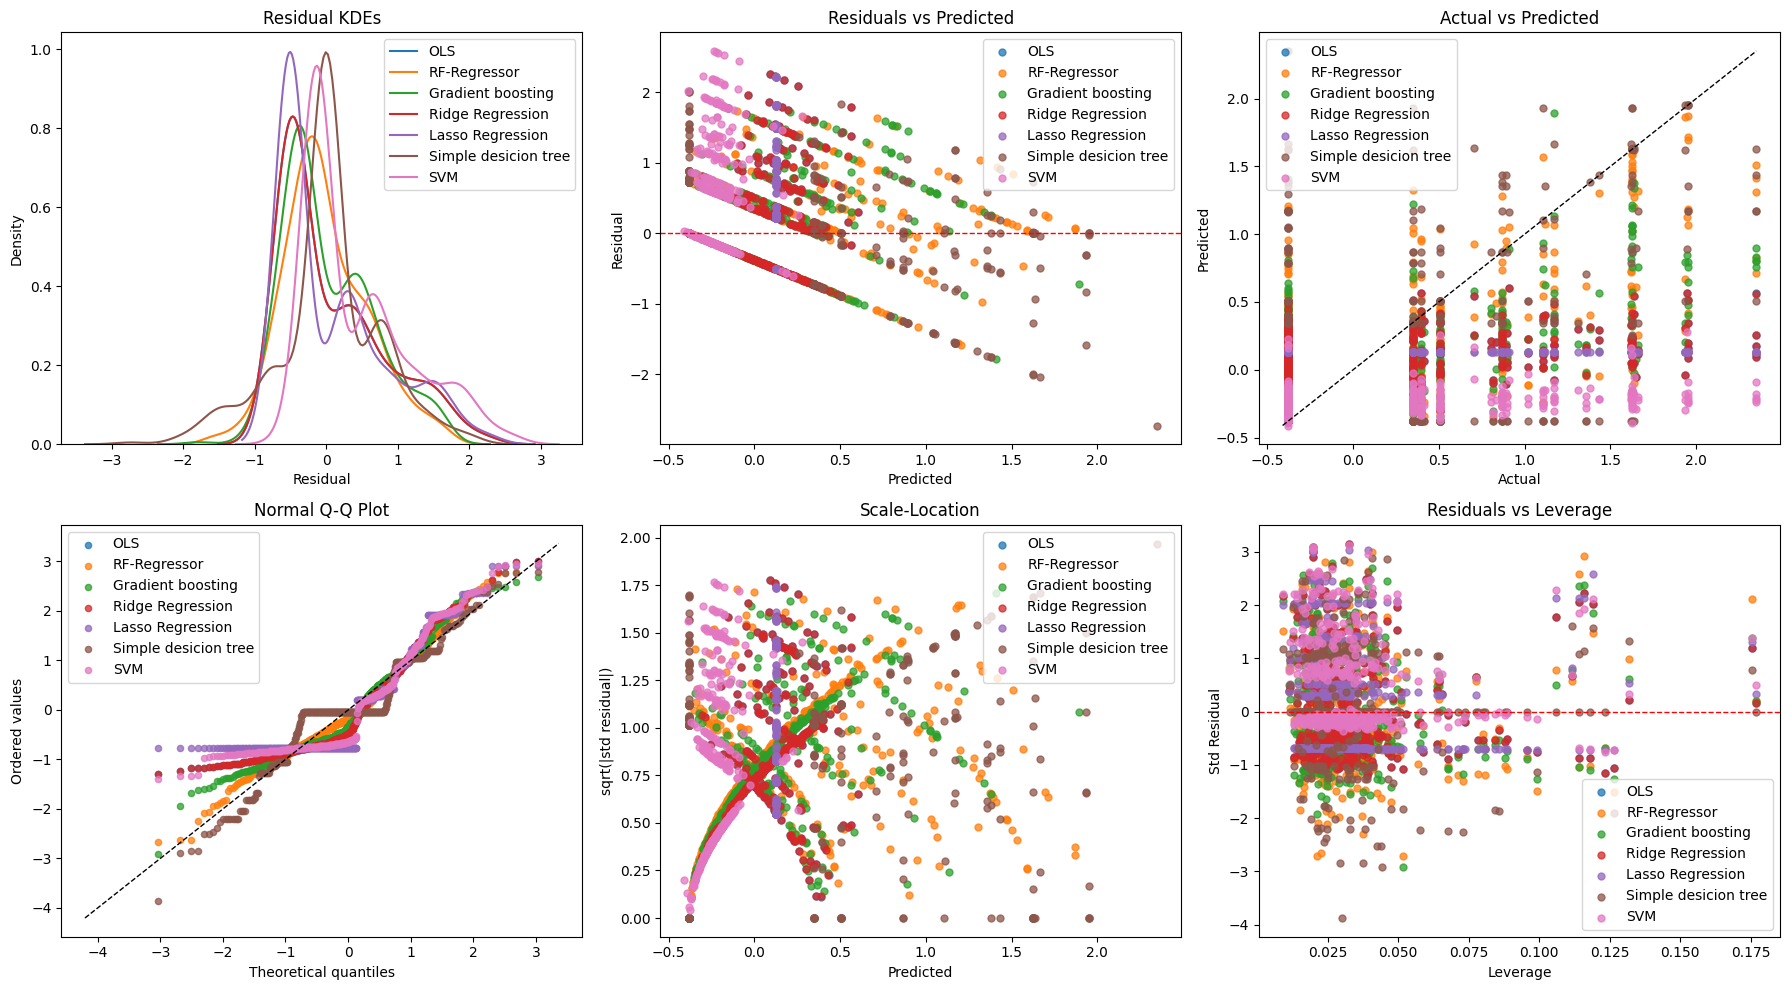

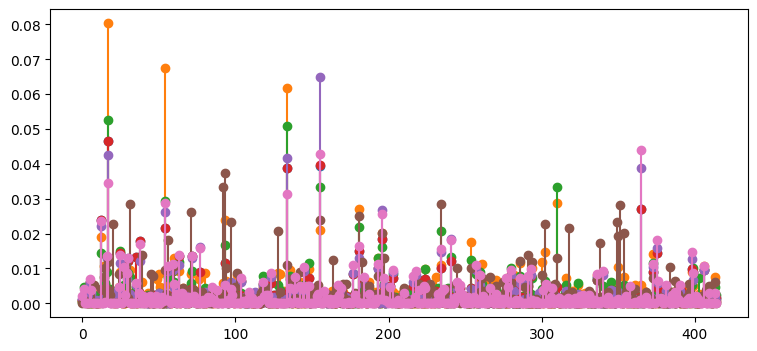

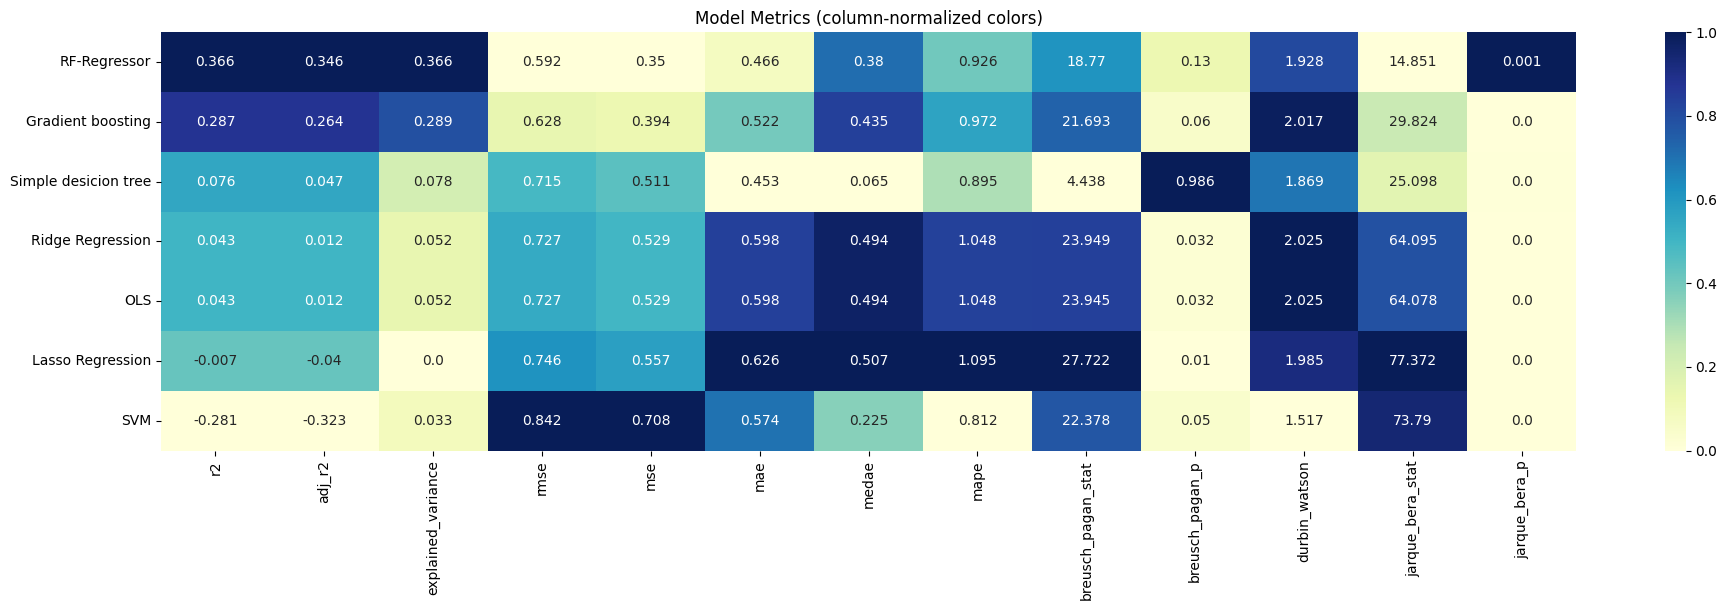

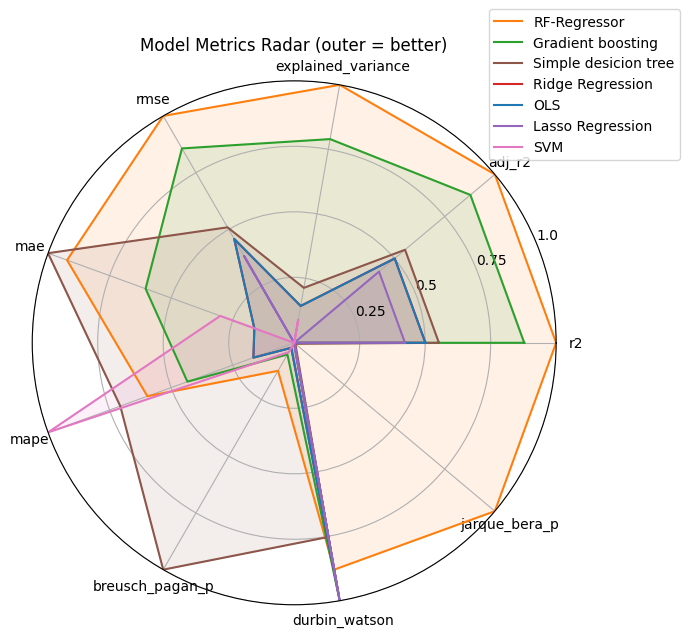

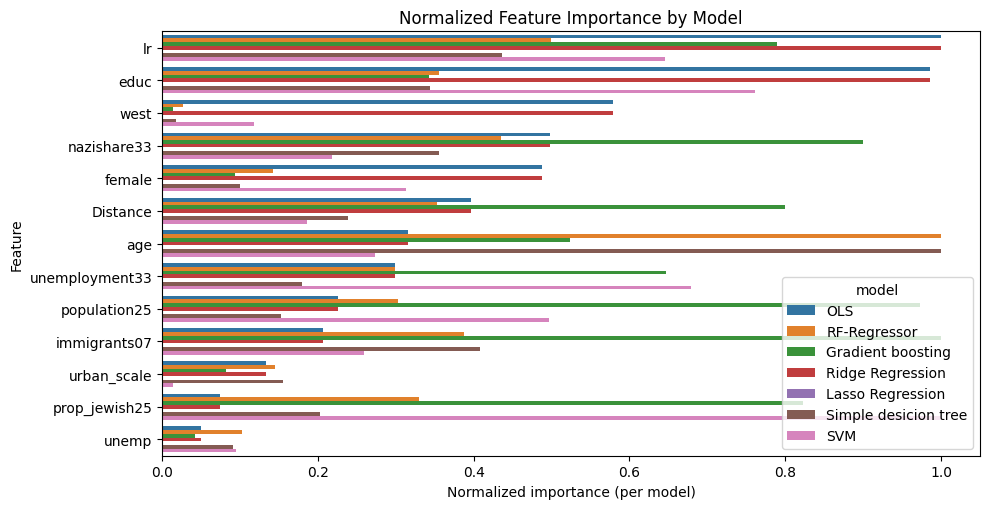

In [144]:
out = regression_evaluation(list(models.items()), X_test, y_test, control_prefixes=control_cols)


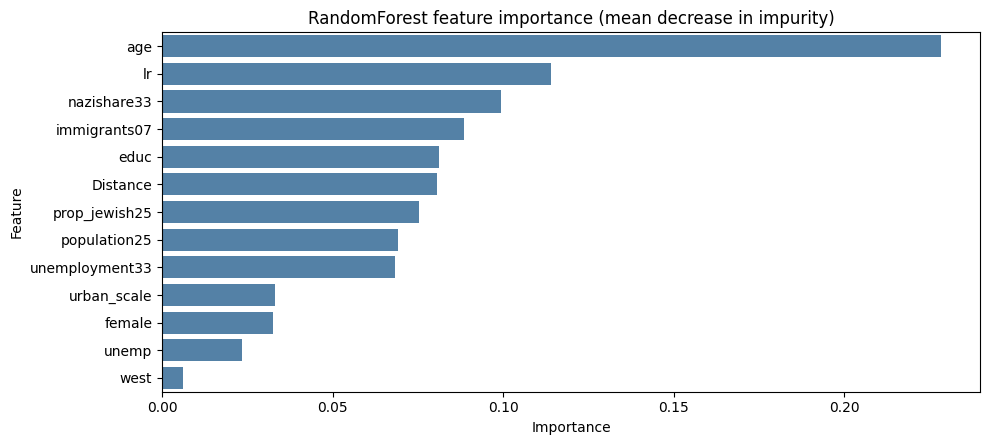

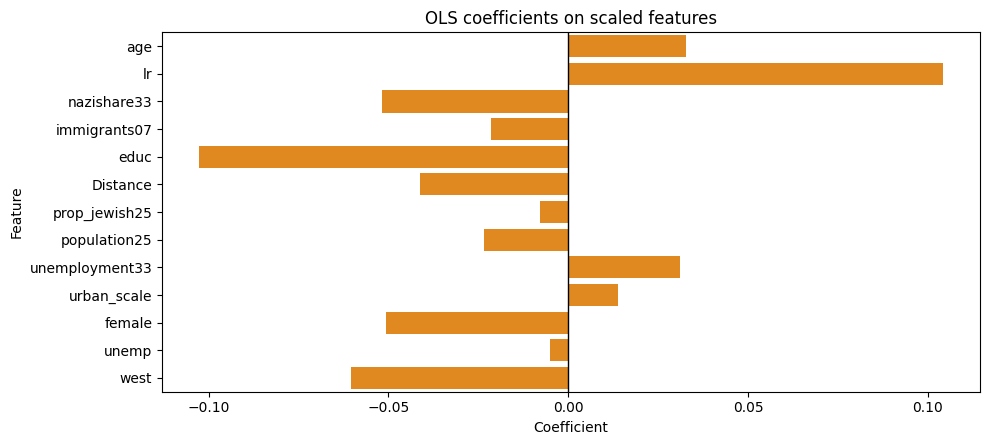

,feature,rf_importance,ols_coefficient
0,age,0.228378,0.032828
1,lr,0.113896,0.104142
2,nazishare33,0.099319,-0.051848
3,immigrants07,0.088389,-0.021464
4,educ,0.081335,-0.102610
5,Distance,0.080627,-0.041329
6,prop_jewish25,0.075262,-0.007770
7,population25,0.069266,-0.023541
8,unemployment33,0.068415,0.031126
9,urban_scale,0.033054,0.013895


In [145]:
# Deep dive: RandomForest regressor feature importance and OLS coefficients
rf_model = models.get("RF-Regressor")
ols_model = models.get("OLS")

if rf_model is None or not hasattr(rf_model, "feature_importances_"):
    raise ValueError("RF-Regressor is missing or not fitted; run model training first.")

feature_names = list(X_train.columns)
rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)

ols_coefs = None
if ols_model is not None and hasattr(ols_model, "coef_"):
    ols_coefs = pd.Series(ols_model.coef_.ravel(), index=feature_names).reindex(rf_importances.index)

fig, ax = plt.subplots(figsize=(10, max(4, len(feature_names) * 0.35)))
sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=ax, color="steelblue")
ax.set_title("RandomForest feature importance (mean decrease in impurity)")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.tight_layout()
plt.show()

if ols_coefs is not None:
    fig, ax = plt.subplots(figsize=(10, max(4, len(feature_names) * 0.35)))
    sns.barplot(x=ols_coefs.values, y=ols_coefs.index, ax=ax, color="darkorange")
    ax.axvline(0, color="black", linewidth=1)
    ax.set_title("OLS coefficients on scaled features")
    ax.set_xlabel("Coefficient")
    ax.set_ylabel("Feature")
    plt.tight_layout()
    plt.show()

summary_df = pd.DataFrame({
    "feature": rf_importances.index,
    "rf_importance": rf_importances.values,
})
if ols_coefs is not None:
    summary_df["ols_coefficient"] = ols_coefs.values

summary_df


# Machine Learning
The code above runs different ML models where I chose the OLS regression from. The charts above show the feature importance of RF alongside with the OLs coefficients. The RF-Regressor was chosen for it't best fit on the features while OLS was chosen for it's godd explainability. The research question states the effect of the Distance on intolerance. The effect will be measured by an coefficient stating the relationship between those variables. The RF in comparison is best for prediction but worst for explainability. 

the coefficient for Distance in the OLS Model above shows an negative impact on the intolerance score, which isn't in Line with the study. In comparison to the study itself we dont use fixed effects of countries here. in comparison with the other coefficient and the facht that the features were scaled using a standartscaler before, the Coefficient can be compared to each other for beter insights. The chart above lines aout that there a different coefficient like education or age explaining the outcome better than the distance. Even in RF Regression the state a hicher feature importance. 

# Reflection
Estimating the causal effect of distance to concentration camps comes with a bunch of assumptions taken by the autors. The researc setup even with controling by fixed effects for Länder has the weakness of unobserved confounders or controling on colliders or mediators. Even with controling for Länder there some uncertanties which effects are captured by länder and for example which effects are captured by education. Like the education plans of the states and the education of the individuals relate to each other the causal structure comes with uncertainties. A better approach maybe would would be to estimate an model for each state and compare those results. In the study the outors estimated one model with wixed effects for länder. In the setup with 16 models the models will be compared. The effect could be compared in between different countries. Only if the effetc holds in all countries in a signifficant way we can assume that there is one.

Futhermore the Autors asume a linear effect of the distance which probably won't be thge case. The assumed effct of cognitive dissonance might take place in the nerer distance to camps but perhaps will go away for wider distances. As there were only 10 contentration camps in germany measuring the effect of the distance for example in Nordrhein-Westfahlen won't be a good coice cause there wasn't any camp. 